In [96]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from src.utils import (
                        line_label_id2label, 
                        line_label_label2id, 
                        line_label_token_id2label, 
                        plot_embeddings, 
                        get_df_classificationreport,
                        pretty_confusion_matrix,)

import pandas as pd

import torch

# MedBERT Finetune on Lines

In [97]:
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
y_true = results["labels"]
last_hidden_state = results["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
y_pred = results["preds"]

In [98]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

In [99]:
display_labels = {k:v.replace("_", "/") for k,v in line_label_id2label.items()}

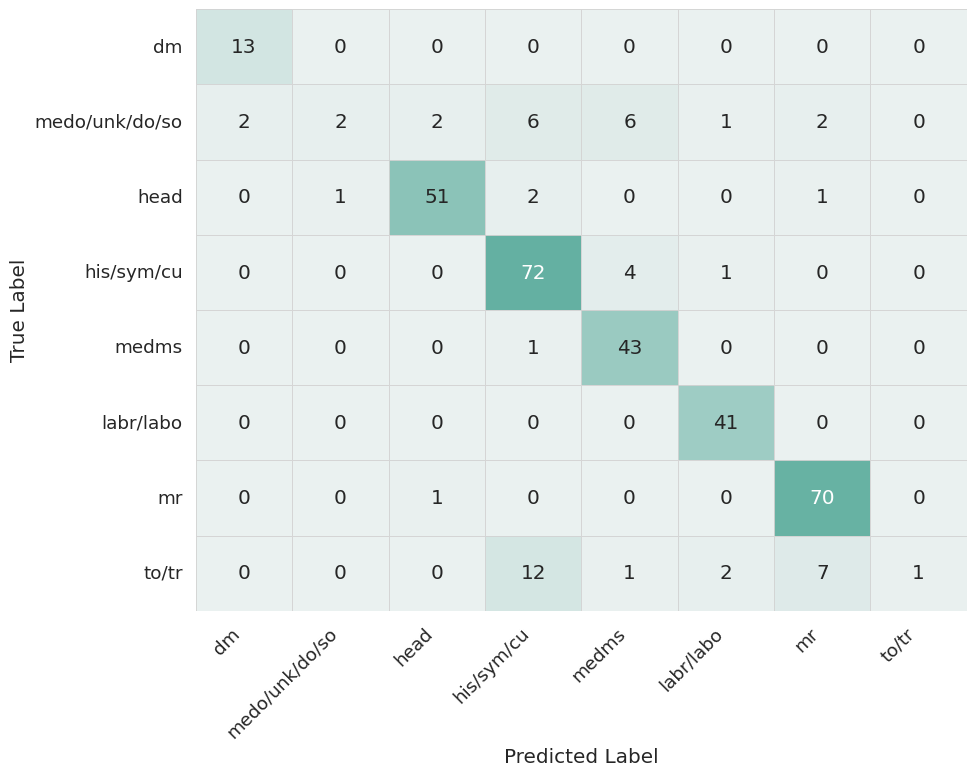

In [100]:
pretty_confusion_matrix(y_true, y_pred, display_labels)

In [101]:
y_valid = [line_label_id2label[label] for label in y_true]
y_pred = [line_label_id2label[pred] for pred in y_pred]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.87,1.00,0.93,13
1,head,0.94,0.93,0.94,55
2,his_sym_cu,0.77,0.94,0.85,77
3,labr_labo,0.91,1.00,0.95,41
4,medms,0.80,0.98,0.88,44
5,medo_unk_do_so,0.67,0.10,0.17,21
6,mr,0.88,0.99,0.93,71
7,to_tr,1.00,0.04,0.08,23
8,accuracy,NaN,NaN,0.85,345
9,macro avg,0.85,0.75,0.71,345


In [102]:
print("Accuracy: ", (pd.Series(y_valid) == pd.Series(y_pred)).mean())

Accuracy:  0.8492753623188406


(345, 2)


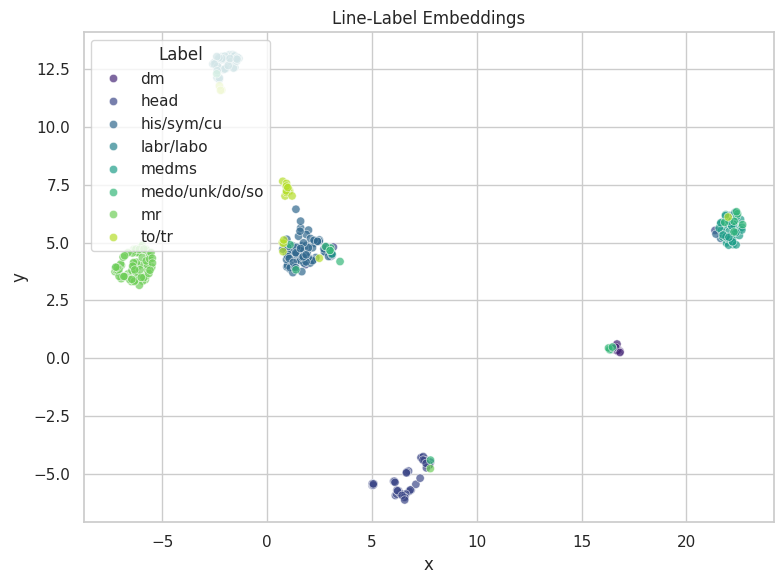

In [103]:
plot_embeddings(embeddings, [line_label_id2label[label].replace("_", "/") for label in y_true], title="Line-Label Embeddings", method="umap", )

In [104]:
# Analysis of FP and TP
# results.pop("last_hidden_state")
# results_df = pd.DataFrame(results)
# results_df.replace(line_label_id2label, inplace = True)

In [105]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_colwidth', None)
# results_df[results_df["preds"] != results_df["labels"]]

In [106]:
# results_df[results_df["labels"] == "head"]

# MedBERT Token Classification

In [107]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [108]:
labels, preds = [], []
for obs in results:
    labels.extend(obs["labs"])
    preds.extend(obs["preds"])
y_true = [line_label_label2id[label] for label in labels]
y_pred = [line_label_label2id[pred] for pred in preds]


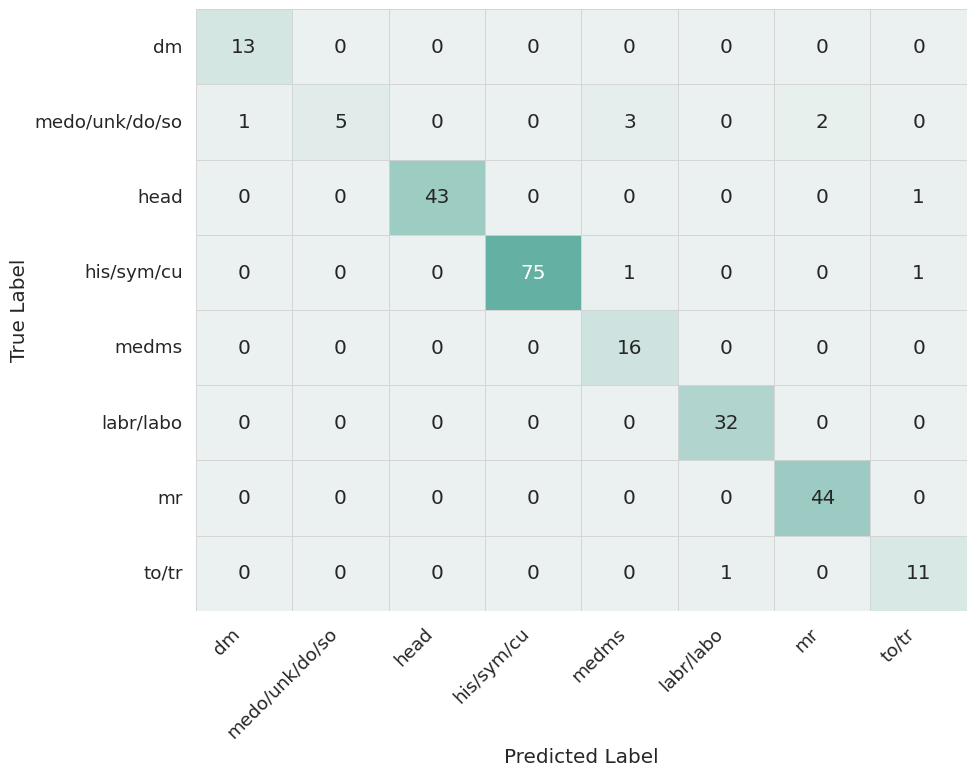

In [109]:
pretty_confusion_matrix(y_true, y_pred, display_labels)

In [110]:
token_results = get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values())).round(2)
token_results

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,1.00,0.98,0.99,44
2,his_sym_cu,1.00,0.97,0.99,77
3,labr_labo,0.97,1.00,0.98,32
4,medms,0.80,1.00,0.89,16
5,medo_unk_do_so,1.00,0.45,0.62,11
6,mr,0.96,1.00,0.98,44
7,to_tr,0.85,0.92,0.88,12
8,accuracy,NaN,NaN,0.96,249
9,macro avg,0.94,0.92,0.91,249


In [111]:
print("Accuracy: ", (pd.Series(y_true) == pd.Series(y_pred)).mean())

Accuracy:  0.9598393574297188


In [112]:
# Hidden States
last_hidden_state = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test_hidden_states.pt")

# Only plot B-labels
b_labels = [label for label in last_hidden_state["labels"] if label in list(range(8))]
b_labels = [line_label_token_id2label[label].replace("_", "/") for label in b_labels]
b_label_idx = [i for i, label in enumerate(last_hidden_state["labels"]) if label in list(range(8))]
b_hidden_states = last_hidden_state["last_hidden_states"][b_label_idx]

(257, 2)


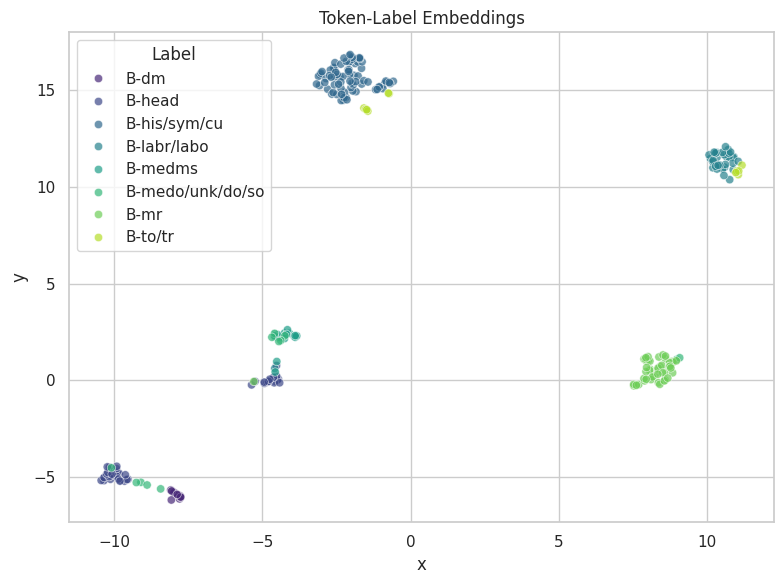

In [113]:
plot_embeddings(b_hidden_states, b_labels, title="Token-Label Embeddings", method="umap")

# Comparing Both models
Need to truncate the outputs of line classifier too

In [114]:
res_line = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
res_token = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [115]:
res_line_rids = pd.DataFrame(res_line["rid"], columns = ["rid"])

In [116]:
indexes = []
lengths = 0
for rid, data in res_line_rids.groupby("rid"):
    # Find corresponding token obs
    for obs in res_token:
        if obs["rid"] == rid:
            length = len(obs["labs"])
            break
    # Select the indexes up to the length of the token obs
    indexes.extend(list(data.index)[:length])

In [117]:
res_line_df = pd.DataFrame(res_line, columns=res_line.keys())
res_line_df = res_line_df.loc[indexes]

In [118]:
y_true = res_line_df["labels"]
last_hidden_state = res_line_df["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
y_pred = res_line_df["preds"]

In [119]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

In [120]:
display_labels = {k:v.replace("_", "/") for k,v in line_label_id2label.items()}

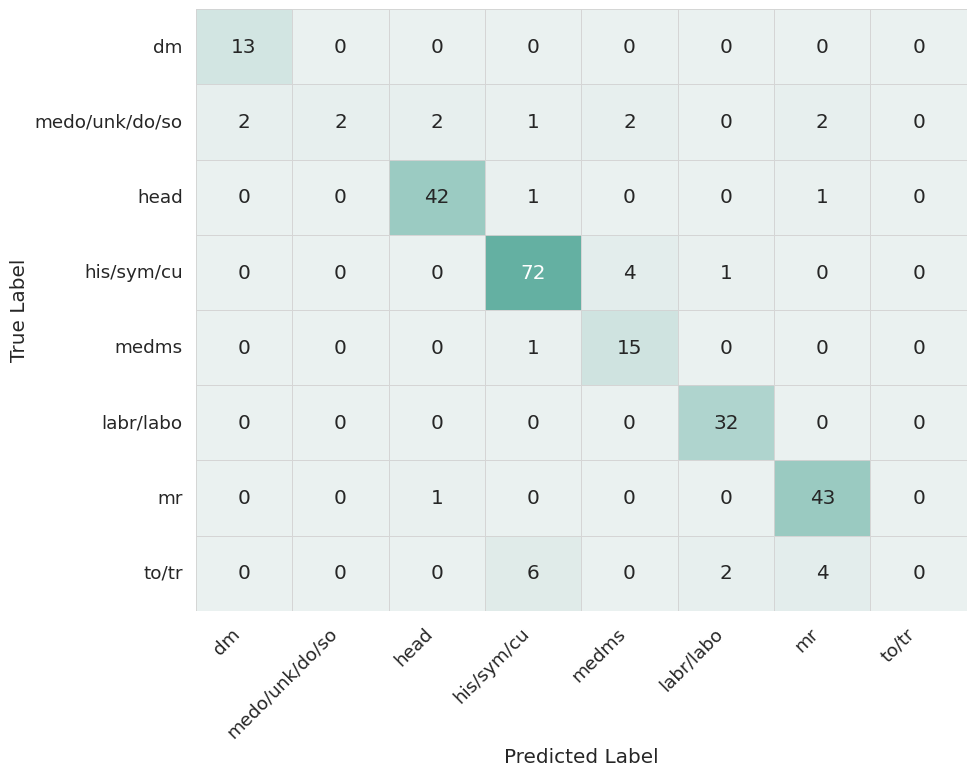

In [121]:
pretty_confusion_matrix(y_true, y_pred, display_labels)

In [122]:
y_valid = [line_label_id2label[label] for label in y_true]
y_pred = [line_label_id2label[pred] for pred in y_pred]
line_results = get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)
line_results

/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/inf-extr-BlECHwmE-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and bein

,eval_measure,precision,recall,f1-score,support
0,dm,0.87,1.00,0.93,13
1,head,0.93,0.95,0.94,44
2,his_sym_cu,0.89,0.94,0.91,77
3,labr_labo,0.91,1.00,0.96,32
4,medms,0.71,0.94,0.81,16
5,medo_unk_do_so,1.00,0.18,0.31,11
6,mr,0.86,0.98,0.91,44
7,to_tr,0.00,0.00,0.00,12
8,accuracy,NaN,NaN,0.88,249
9,macro avg,0.77,0.75,0.72,249


In [123]:
print("Accuracy: ", (pd.Series(y_valid) == pd.Series(y_pred)).mean())

Accuracy:  0.8795180722891566


(249, 2)


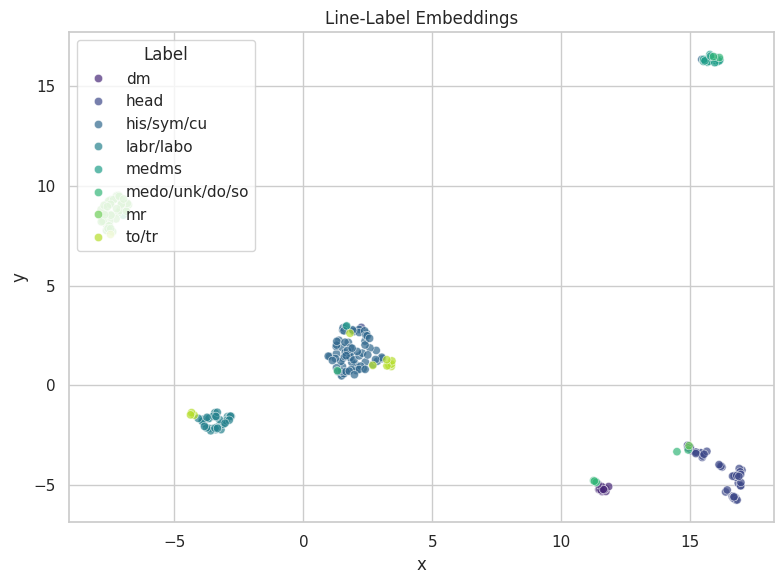

In [124]:
plot_embeddings(embeddings, [line_label_id2label[label].replace("_", "/") for label in y_true], title="Line-Label Embeddings", method="umap", )

In [135]:
print(pd.concat([line_results.iloc[:, :-1], token_results.iloc[:, 1:-1]], axis = 1).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
eval_measure & precision & recall & f1-score & precision & recall & f1-score \\
\midrule
dm & 0.87 & 1.00 & 0.93 & 0.93 & 1.00 & 0.96 \\
head & 0.93 & 0.95 & 0.94 & 1.00 & 0.98 & 0.99 \\
his_sym_cu & 0.89 & 0.94 & 0.91 & 1.00 & 0.97 & 0.99 \\
labr_labo & 0.91 & 1.00 & 0.96 & 0.97 & 1.00 & 0.98 \\
medms & 0.71 & 0.94 & 0.81 & 0.80 & 1.00 & 0.89 \\
medo_unk_do_so & 1.00 & 0.18 & 0.31 & 1.00 & 0.45 & 0.62 \\
mr & 0.86 & 0.98 & 0.91 & 0.96 & 1.00 & 0.98 \\
to_tr & 0.00 & 0.00 & 0.00 & 0.85 & 0.92 & 0.88 \\
accuracy & NaN & NaN & 0.88 & NaN & NaN & 0.96 \\
macro avg & 0.77 & 0.75 & 0.72 & 0.94 & 0.92 & 0.91 \\
weighted avg & 0.84 & 0.88 & 0.85 & 0.96 & 0.96 & 0.96 \\
custom_weighted & 0.83 & 0.96 & 0.89 & 0.92 & 0.99 & 0.95 \\
\bottomrule
\end{tabular}

